# Implementing protein components
this jnb gives you quick access to the implementation of protein components.


In [ ]:
import gufe

## Dev function

In [ ]:
#input:
pdb_path= "./thrombin_protein.pdb"


In [ ]:
#Imports
from gufe.components.sub_files.pdbfile import PDBFile #Vendored code - import

from rdkit import Chem
from rdkit.Chem.rdchem import Mol, Atom, Conformer, EditableMol, BondType


In [ ]:
openmm_PDBFile = PDBFile(pdb_path)

In [ ]:
bond_types = {  1 : BondType.SINGLE,
                2 : BondType.DOUBLE,
                3 : BondType.TRIPLE ,
               None :  BondType.SINGLE,
               }

negative_ions = ["CL"]
positive_ions = ["NA", "MG"]

In [ ]:
            
periodicTable = Chem.GetPeriodicTable()
mol_topology = openmm_PDBFile.topology

rd_mol = Mol()
editable_rdmol = EditableMol(rd_mol)

# Build Topology
histidine_resi_atoms = {}
# Add Atoms
for atom in mol_topology.atoms():
    atomID_orig = int(atom.index)
    a = Atom(atom.element.atomic_number)
    a.SetAtomMapNum(atomID_orig)

    a.SetProp("name", atom.name)
    a.SetIntProp("id", atomID_orig)

    a.SetProp("resName", atom.residue.name)
    a.SetIntProp("resId", int(atom.residue.index))

    mi  =  Chem.AtomPDBResidueInfo()
    mi.SetResidueName(atom.residue.name)
    mi.SetResidueNumber( int(atom.residue.index))
    mi.SetOccupancy(0.0)
    mi.SetTempFactor(0.0)
    
    a.SetMonomerInfo(mi)

    if("HIS" ==  atom.residue.name):
        if(int(atom.residue.index) in histidine_resi_atoms):
            histidine_resi_atoms[int(atom.residue.index)].append(atom.name)
        else:
            histidine_resi_atoms[int(atom.residue.index)] = [atom.name]
        
    editable_rdmol.AddAtom(a)


# Add Bonds
for bond in mol_topology.bonds():
    bond_order = bond_types[bond.order]  
    editable_rdmol.AddBond(beginAtomIdx=bond.atom1.index, endAtomIdx=bond.atom2.index, order=bond_order)    

# Set Positions
rd_mol = editable_rdmol.GetMol()
positions = list(map(list, openmm_PDBFile.positions._value))
conf = Conformer(0)
for atom_id, atom_pos in enumerate(positions):
    conf.SetAtomPosition(atom_id, atom_pos) #unit: nm
rd_mol.AddConformer(conf)

# Molecule props
# Adding nums:
rd_mol.SetIntProp("NumAtoms", mol_topology.getNumAtoms())
rd_mol.SetIntProp("NumBonds", mol_topology.getNumBonds())
rd_mol.SetIntProp("NumChains", mol_topology.getNumChains())

# dimensions
pbcVs = list(map(list, mol_topology.getPeriodicBoxVectors()._value)) #unit: nm
unitCellDim = list(map(float, mol_topology.getUnitCellDimensions()._value)) #unit: nm
rd_mol.SetProp("PeriodicBoxVectors", str(pbcVs))
rd_mol.SetProp("UnitCellDimensions", str(unitCellDim))

# Sequence Settings
residue_names = [r.name for r in mol_topology.residues()]
res_seq = " ".join(residue_names) 
rd_mol.SetProp("sequence", res_seq)

# Chains
rd_mol.SetProp("chain_names", str([c.index for c in mol_topology.chains()]))
rd_mol.SetProp("chain_resi", str([[r.index for r in c.residues()] for c in mol_topology.chains()]))


# Add Additionals
# Formal Charge
atoms = rd_mol.GetAtoms()
netcharge = 0
for a in atoms:
    atomic_num = a.GetAtomicNum()
    atom_name = a.GetProp("name")

    connectivity = sum([int(bond.GetBondType()) for bond in a.GetBonds()]) #
    
    default_valence = periodicTable.GetDefaultValence(atomic_num)
    
    # HISTIDINE FIX  resonance
    # Due to the resonance of the Ns in His (which are frequently de/protonating in proteins), there can be bond type changes between ND1-CE1-NE2. 
    if("HIS" == a.GetProp("resName") and "N" in a.GetProp("name") and len(a.GetProp("name"))>1):
        resi = int(a.GetProp("resId"))

        histidine_atoms = histidine_resi_atoms[resi]
        own_prot = a.GetProp("name").replace("N", "H") in histidine_atoms
        other_N = list(filter(lambda x: x.startswith("N") and len(x) > 1 and not atom_name== x, histidine_atoms))[0]
        other_prot = other_N.replace("N", "H") in histidine_atoms

        if(own_prot and not other_prot and connectivity != default_valence):
            #change bond-order
            bond_change = [bond for bond in a.GetBonds() if("CE1" in (bond.GetBeginAtom().GetProp("name"),
                                                                      bond.GetEndAtom().GetProp("name")))][0]
            bond_change.SetBondType(bond_types[1])
            
            alternate_atom = [a for a in rd_mol.GetAtoms() if(a.GetProp("resId") == str(resi) and a.GetProp("name") == str(other_N))][0]
            bond_change = [bond for bond in alternate_atom.GetBonds() if("CE1" in (bond.GetBeginAtom().GetProp("name"),
                                                                                   bond.GetEndAtom().GetProp("name")))][0]
            bond_change.SetBondType(bond_types[2])  
        connectivity = sum([int(bond.GetBondType()) for bond in a.GetBonds()])

    ### HISTIDINE FIX DONE
    
    if(connectivity == 0): #ions:
        if(atom_name in positive_ions):
            fc = default_valence  #e.g. Sodium ions
        elif(atom_name in negative_ions):
            fc = -default_valence  #e.g. Chlorine ions
        else:
            raise ValueError("I don't know this Ion! \t"+atom_name)     
    elif(default_valence > connectivity):
        fc = -(default_valence-connectivity) # negative charge
    elif(default_valence < connectivity):
        fc = +(connectivity-default_valence) # positive charge
    else:
        fc = 0 # neutral
        
    a.SetFormalCharge(fc)
    a.UpdatePropertyCache(strict=True)
       

    if(False and fc!=0): #Os => atomic_num==8; Ns => atomic_num==7; Na => atomic_num == 11
        print(a.GetProp("resName"), a.GetProp("resId"), 
              a.GetProp("name"), a.GetIdx(),
              fc, connectivity, default_valence)

    netcharge+=fc
    
rd_mol.SetDoubleProp("NetCharge", netcharge)
rd_mol.UpdatePropertyCache(strict=True)

In [ ]:
rd_mol

## Test

In [ ]:
#WIP

## Class Implementation

/home/riesbenj/Code/OpenFE/gufe/gufe/components/sub_files/pdbstructure.py:488: UserWarning: WARNING: two consecutive residues with same number (ATOM   4449  N   CYS L   4      10.968  17.388  19.471  1.00 16.59      L    N  , ATOM   4448  HB2 ASP L   4      10.396  20.895  17.001  1.00 39.37      L    H  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))


A ION! 1
A ION! 1


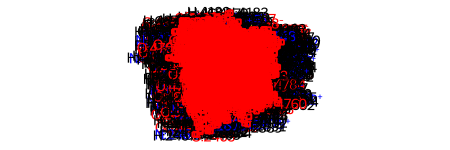

In [1]:
from gufe import ProteinComponent
pdb_path= "./thrombin_protein.pdb"

prot = ProteinComponent.from_pdbfile(pdb_path, name="thrombin")
prot._rdkit

In [2]:
out_pdb_path= "./thrombin_protein_new.pdb"

prot.to_pdb(out_pdb_path)

'./thrombin_protein_new.pdb'

## Build a bond ordered xml

In [ ]:
import xml.etree.ElementTree as etree

out_path = "../gufe/components/sub_files/data/residues.xml"
in_path = "../gufe/components/sub_files/data/residues_orig.xml"


exception_bond_keys = {
            # AminoAcids
            ##Backbone
            ('C', 'O'): { "order": 2, "resns": "all"},
            
            ## Carbonyls in R
            ("CZ", "NH2"): { "order": 2, "resns": ("ARG")},
            ("CG", "OD1"):{ "order": 2, "resns":  ("ASP", "ASN")},
            ("CD", "OE1"):{ "order": 2, "resns": ("GLN", "GLU")},
            ("CD", "OE"):{ "order": 2, "resns": ("PCA")},
            
            ## Aromatics:
            ("CD2", "CG"):{ "order": 2, "resns": ("HIS")},
            ("CE1", "ND1"):{ "order": 2, "resns": ("HIS")},
            
            ("CG", "CD1"):{ "order": 2, "resns": ("PHE", "TYR", "TRP")},
            ("CE1", "CZ"):{ "order": 2, "resns": ("PHE", "TYR")},
            ("CE2", "CD2"):{ "order": 2, "resns": ("PHE", "TYR")},
            
            ("CD2", "CE3"):{ "order": 2, "resns": ("TRP")},
            ("CE2", "CZ2"):{ "order": 2, "resns": ("TRP")},
            ("CZ3", "CH2"):{ "order": 2, "resns": ("TRP")},

            # NucleicAcids
            ## Phosphates
            ("OP1", "P"):{ "order": 2, "resns": ("U", "G", "A", "C", "DT", "DG", "DC", "DA")},
            
            ## Pyrimidines: Uracil, Thymin and Cytosin
            ("C2", "O2"):{ "order": 2, "resns": ("U", "DT", "C", "DC")},
            ("C5", "C6"):{ "order": 2, "resns": ("U", "DT", "C", "DC")},
            ("C4", "O4"):{ "order": 2, "resns": ("U", "DT")},
            ("C4", "N3"):{ "order": 2, "resns": ("C", "DC")},

            ## Purines: Guanine, Adenine
            ("C2", "N3"):{ "order": 2, "resns": ("G", "DG", "A", "DA")},
            ("C4", "C5"):{ "order": 2, "resns": ("G", "DG", "A", "DA")},
            ("N7", "C8"):{ "order": 2, "resns": ("G", "DG", "A", "DA")},
            ("C6", "O6"):{ "order": 2, "resns": ("G", "DG")},
            ("C6", "N1"):{ "order": 2, "resns": ("A", "DA")},            
             }
#sort keys :
exception_bond_keys = {tuple(sorted(list(key))): value for key, value in exception_bond_keys.items()}
#print(exception_bond_keys)


tree = etree.parse(in_path)

for residue in tree.getroot().findall('Residue'):
    resn = residue.get("name")
    for bond in residue.findall("Bond"):
        c1 = bond.get("from")
        c2 = bond.get("to")
        bond_atoms=tuple(sorted([c1, c2]))
        if(bond_atoms in exception_bond_keys and (exception_bond_keys[bond_atoms]["resns"] == "all" or resn in exception_bond_keys[bond_atoms]["resns"])):
            bond.set("order", str(exception_bond_keys[bond_atoms]["order"]))
        else:
            bond.set("order", str(1))
        #if(resn == "PHE"): print(bond_atoms, bond.get("order"))

tree.write(out_path)